# Real music example

## Detect when an instrument is playing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, GRU, Flatten, MaxPool2D, MaxPool1D
from tensorflow.keras.layers import PReLU, Dropout, Lambda, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

from music_generator.basic.random import generate_dataset
from music_generator.basic.signalproc import SamplingInfo
from music_generator.musical.timing import Tempo
from music_generator.musical.scales import GenericScale
from music_generator.basic.signalproc import mix_at
from music_generator.analysis import preprocessing

from music_generator.musical import scales
import numpy as np
from multiprocessing import Pool
from functools import partial

import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline
import matplotlib

from scipy.io.wavfile import read
import pandas as pd

In [3]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

## Load data

In [4]:
sr, full_mix = read("../data/full-mix.wav", mmap=False)
sr, only_guitar = read("../data/only-guitar.wav", mmap=False)

full_mix = full_mix.astype(np.float) / 2**15
only_guitar = only_guitar.astype(np.float) / 2**15

/home/marcelra/PycharmProjects/mg-desktop/venv/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


## Visualize the full mix

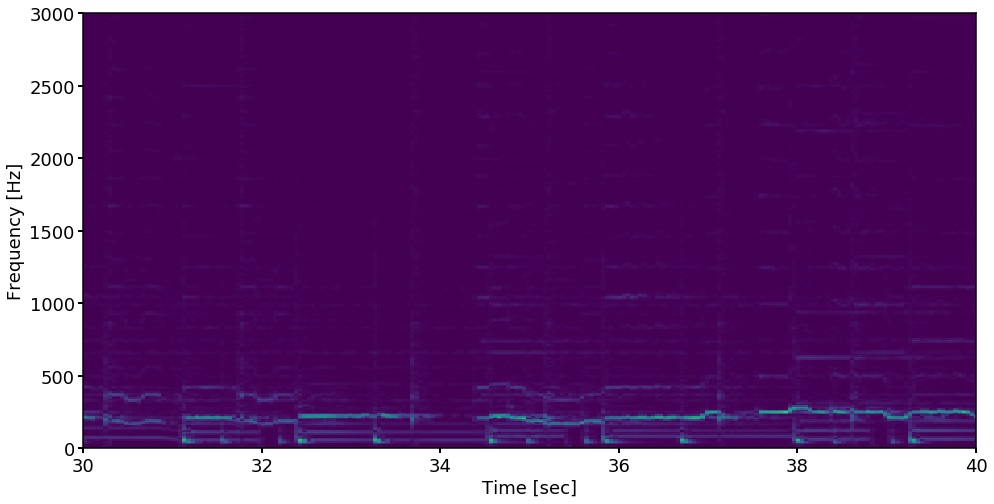

In [5]:
from scipy.signal import stft
f_vec, t_vec, Zxx = stft(full_mix, sr, nperseg=4096)
plt.pcolormesh(t_vec, f_vec, np.abs(Zxx), vmin=0, vmax=0.5)
# plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 3000)
plt.xlim(30, 40);

## Detect where guitar is playing in its solo track

In [6]:
df = pd.DataFrame({'guitar': only_guitar}, index=np.arange(len(only_guitar))/ 44100)
df['full_mix'] = full_mix
df['rolling_mse'] = df['guitar'].rolling(window=4000, center=False).std()
df['is_playing'] = df['rolling_mse'] > 0.1
df['is_playing_float'] = df['is_playing'] * 1.0
df['signal_masked'] = df['is_playing'] * df['guitar']

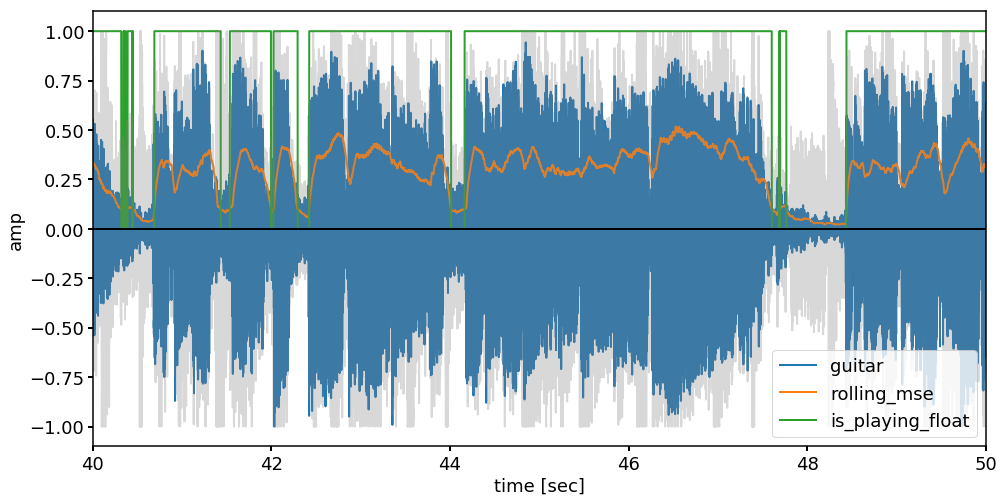

In [7]:
t0 = 40
delta = 10
df.loc[t0:t0+delta][['guitar', 'rolling_mse', 'is_playing_float']].plot()
df.loc[t0:t0+delta]['full_mix'].plot(color='0.5', alpha=0.3)
plt.axhline(y=0, color='k')
plt.ylabel('amp')
plt.xlabel('time [sec]');

In [8]:
Audio(df['signal_masked'].values[20*sr:30*sr], rate=sr)

## Make data set

In [9]:
def create_random_fragment_indices(n_batches, n_samples, fragment_length):
    i_max = n_samples - fragment_length
    start = np.random.randint(low=0, high=i_max, size=n_batches)
    
    return np.array([np.arange(s, s+fragment_length) for s in start])

In [10]:
x_train = df['full_mix'].values
y_train = df['is_playing'].values

fragment_length = 4096
n_fragments = 20000

ind = create_random_fragment_indices(n_fragments, len(x_train), fragment_length)

In [11]:
x_train = x_train[ind]
y_train = y_train[ind]

In [12]:
x_train = x_train.reshape(-1, fragment_length)
y_train = y_train.reshape(-1, fragment_length)

y_train = np.percentile(y_train, q=80, axis=1).reshape(-1, 1)

# Class balancing
w0 = 0.5*len(x_train) / np.sum(y_train == 0) 
w1 = 0.5*len(x_train) / np.sum(y_train == 1)
sample_weight = np.where(y_train==0, w0, w1).reshape(-1)

## Build model

* We are going to chop up again in fragments of 0.1 seconds (which is the time resolution)
* For each fragment we are know whether guitar is playing or not

    ```
    Short fragment (~0.1 seconds) -> Model -> is_playing
    ```

In [17]:
import tensorflow as tf

inp = Input(shape=[fragment_length])
out = inp

def apply_fft(tensor):
    tensor = tf.cast(tensor, tf.complex64)
    return tf.abs(tf.signal.fft(tensor))

out = Lambda(apply_fft, output_shape=[fragment_length])(out)
out = Dense(units=1, activation='sigmoid')(out)

model = Model(inp, out)
model.summary()
model.compile(Adam(lr=1e-3), 'binary_crossentropy', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4096)]            0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4097      
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [18]:
model.fit(x_train, y_train, epochs=10, validation_split=0.2, sample_weight=sample_weight)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 11s 665us/sample - loss: 0.7238 - accuracy: 0.8723 - val_loss: 0.8249 - val_accuracy: 0.8075
Epoch 2/10
16000/16000 [==============================] - 11s 660us/sample - loss: 0.4457 - accuracy: 0.9026 - val_loss: 0.9711 - val_accuracy: 0.7720
Epoch 3/10
16000/16000 [==============================] - 11s 658us/sample - loss: 0.4772 - accuracy: 0.9044 - val_loss: 0.3432 - val_accuracy: 0.9175
Epoch 4/10
16000/16000 [==============================] - 11s 658us/sample - loss: 0.4561 - accuracy: 0.9152 - val_loss: 0.3715 - val_accuracy: 0.9275
Epoch 5/10
16000/16000 [==============================] - 11s 660us/sample - loss: 0.3402 - accuracy: 0.9261 - val_loss: 0.2914 - val_accuracy: 0.9323
Epoch 6/10
16000/16000 [==============================] - 11s 660us/sample - loss: 0.3166 - accuracy: 0.9243 - val_loss: 0.9023 - val_accuracy: 0.9107
Epoch 7/10
16000/16000 [=====================

## Make prediction

In [19]:
df = df.iloc[0:((len(df) // fragment_length) * fragment_length)].copy()
x_pred = df.full_mix.values.reshape(-1, fragment_length)
y_pred = model.predict(x_pred)
df['is_playing_prediction'] = y_pred.repeat(fragment_length)

## Visualize prediction using moviepy



In [21]:
import moviepy as mpy
from moviepy.editor import VideoClip, AudioFileClip, clips_array
from moviepy.video.io.bindings import mplfig_to_npimage

chunk:   1%|          | 68/5521 [00:00<00:08, 668.58it/s, now=None]

Moviepy - Building video detection.mp4.
MoviePy - Writing audio in %s


t:   0%|          | 0/6008 [00:00<?, ?it/s, now=None]

MoviePy - Done.
Moviepy - Writing video detection.mp4



Moviepy - Done !
Moviepy - video ready detection.mp4


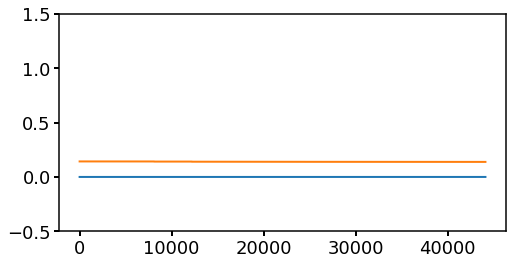

In [22]:
matplotlib.rcParams['figure.figsize'] = (8.0, 4.0)

fig, ax = plt.subplots()
def make_frame1(t):
    ax.clear()
    ix = df.index.searchsorted(t)
    c = '0.5' if df.iloc[ix]['is_playing_prediction'] < 0.5 else 'b'
    ax.plot(df.loc[t-0.2:t]['full_mix'].values, color=c)
    ax.set_ylim(-2, 2)
    return mplfig_to_npimage(fig)

def make_frame2(t):
    ax.clear()
    ix = df.index.searchsorted(t)
    c = '0.5' if df.iloc[ix]['is_playing_prediction'] < 0.5 else 'b'
    ax.plot(df.loc[t-0.2:t]['guitar'].values, color=c)
    ax.set_ylim(-2, 2)
    return mplfig_to_npimage(fig)

def make_frame3(t):
    ax.clear()
    ax.plot(df.loc[t-1:t]['is_playing'].values)
    ax.plot(df.loc[t-1:t]['is_playing_prediction'].values)
    ax.set_ylim(-0.5, 1.5)
    return mplfig_to_npimage(fig)

duration = df.index.max()
# duration = 10

clip1 = VideoClip(make_frame1, duration=duration)
clip2 = VideoClip(make_frame2, duration=duration)
clip3 = VideoClip(make_frame3, duration=duration)

audio = AudioFileClip("../data/full-mix.wav", fps=44100)
clip1.audio = audio

final_clip = clips_array([[clip1, clip3]])
# final_clip.ipython_display(fps=20, autoplay=True, maxduration=300)
final_clip.to_videofile("detection.mp4", fps=24)

# Let's listen and watch the predictions

In [23]:
from IPython.display import Video
Video('detection.mp4')